# Multi-Level Models (Hierarchical Models)

So far, we haven't considered the probability distribution of the fitting parameters $D_0,k_1,k_2$, and $k_3$. But to use a hierarchical model to combine our inference from different patch data and allow us to model our serum estradiol concentration, we will need to introduce hyperparameters that connect different studies. This way, our fitting parameters are given a "probabilistic specification" in terms of hyperparameters that are common for all. In our case, the hyperparameters would be the parameters of the distribution ([hyperprior](https://en.wikipedia.org/wiki/Hyperprior)) we choose to use in order to model our fitting parameters.

# Before and After Patch Removal

We can see from [3_Steady-State_Multi-Dose_3-Compartment](3_Steady-State_Multi-Dose_3-Compartment) that the decay after patch removal is not captured when the serum Estradiol solution didn't consider measurement after patch removal as a separate process.

After patch removal, the estradiol concentration within the depot $d_0$ (and thus $D(t_0)$) is zero.

We then [evolve](https://discord.com/channels/438306949285806082/1201973466845151362/1206123175331627029) our solution $E_2(t)$ with the initial condition at patch removal $t_{\rm rem}$ to be given by $A_{\rm eff}(t_{\rm rem})$ and $E_2(t_{\rm rem})$. i.e., we have for $E_2(t)$ after $t_{\rm rem}$

$$E_2^{t_{\rm rem}}(t)=\frac{k_2A_{\rm eff}(t_{\rm rem})}{k_2-k_3}\left[-\frac{e^{-k_2(t-T\operatorname{floor}(t/T))}}{1-e^{-k_2T}}+\frac{e^{-k_3(t-T\operatorname{floor}(t/T))}}{1-e^{-k_3T}}\right]+E_2(t_{\rm rem})\frac{e^{-k_3(t-T\operatorname{floor}(t/T))}}{1-e^{-k_3T}}.$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import arviz as az
#import theano.tensor as tt    # https://discourse.pymc.io/t/defining-an-array-to-store-rv-before-they-are-introduced-in-the-likelihood/1373

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import jax
jax.default_backend()

'gpu'

In [3]:
# import and visualize data

MylanTDPDays100 = np.genfromtxt('Data/DailyMed_MylanTDP_n36/MylanTDP_n36_100mcg.csv', delimiter=',', skip_header=True)
MylanTDPDays50 = np.genfromtxt('Data/DailyMed_MylanTDP_n36/MylanTDP_n36_50mcg.csv', delimiter=',', skip_header=True)
MylanTDPDays25 = np.genfromtxt('Data/DailyMed_MylanTDP_n36/MylanTDP_n36_25mcg.csv', delimiter=',', skip_header=True)

H2003aN30Estradot100 = np.genfromtxt('Data/Hossain2003a_Estradot_n30/H2003a_Estradot_n30_100mcg.csv', delimiter=',', skip_header=True)
H2003aN30Estradot50 = np.genfromtxt('Data/Hossain2003a_Estradot_n30/H2003a_Estradot_n30_50mcg.csv', delimiter=',', skip_header=True)
H2003aN30Estradot37_5 = np.genfromtxt('Data/Hossain2003a_Estradot_n30/H2003a_Estradot_n30_37.5mcg.csv', delimiter=',', skip_header=True)
H2003aN30Estradot25 = np.genfromtxt('Data/Hossain2003a_Estradot_n30/H2003a_Estradot_n30_25mcg.csv', delimiter=',', skip_header=True)

H2003bN11Estradot100 = np.genfromtxt('Data/Hossain2003b_Estradot_n11/H2003b_Estradot_n11_100mcg.csv', delimiter=',', skip_header=True)
H2003bN11Estradot50 = np.genfromtxt('Data/Hossain2003b_Estradot_n11/H2003b_Estradot_n11_50mcg.csv', delimiter=',', skip_header=True)

# exclude n = 30 study from H2003b due to the initial measurement being higher than the second measurement
#H2003bN30Estradot50 = np.genfromtxt('Data/Hossain2003b_Estradot_n30/H2003b_Estradot_n30_50mcg.csv', delimiter=',', skip_header=True)

# convert Mylan data from days to hrs, Estradot data is already in hrs
# https://stackoverflow.com/questions/10394659/how-to-add-a-calculated-computed-column-in-numpy

MylanTDP100 = np.vstack((MylanTDPDays100[:,0]*24, MylanTDPDays100[:,1])).T
MylanTDP50 = np.vstack((MylanTDPDays50[:,0]*24, MylanTDPDays50[:,1])).T
MylanTDP25 = np.vstack((MylanTDPDays25[:,0]*24, MylanTDPDays25[:,1])).T

In [4]:
def E2(t, d0, k1, k2, k3):
    summation = 0
    innerFunc1 = pm.math.exp(-k1 * t) / ((k1 - k2) * (k1 - k3))
    innerFunc2 = pm.math.exp(-k2 * t) / ((k1 - k2) * (k2 - k3))
    innerFunc3 = pm.math.exp(-k3 * t) / ((k1 - k3) * (k2 - k3))
    summation = d0 * (innerFunc1 - innerFunc2 + innerFunc3)
    return k1 * k2 * summation

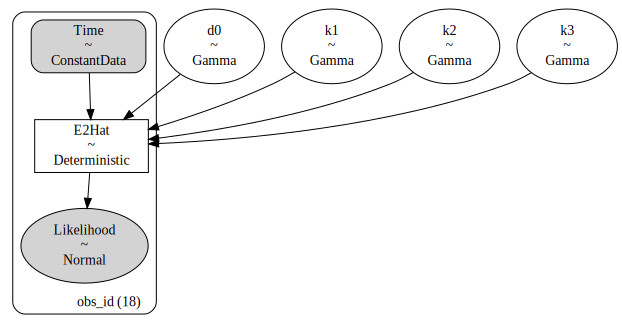

In [96]:
# https://github.com/obscode/FlyingCircus/blob/master/MoreNotebooks/ModelFitting/Pymc.ipynb
# https://www.pymc.io/projects/examples/en/latest/introductory/api_quickstart.html#deterministic-transforms

# LaTeX needs to be treated as raw string literal for az to work, https://lightrun.com/answers/arviz-devs-arviz-latex-label-compatibility-issues-while-using-bokeh-as-backend, https://stackoverflow.com/questions/2081640/what-exactly-do-u-and-r-string-prefixes-do-and-what-are-raw-string-literals
# better not use LaTeX for variable names due to issues with plotting via az.plot_ppc

# https://github.com/pymc-devs/pymc-examples/blob/main/examples/generalized_linear_models/multilevel_modeling.ipynb

Mylan100Model = pm.Model()

with Mylan100Model:
    # import data, https://www.pymc.io/projects/docs/en/latest/api/generated/pymc.get_data.html
    Mylan100TimeData = pm.ConstantData("Time", MylanTDP100[:,0], dims="obs_id")
    #Mylan100Data = pm.ConstantData("E2Observed", MylanTDP100[:,1], dims="obs_id")
    sigma = pm.math.sqrt(MylanTDP100[:,1])    # Standard deviation

    # priors
    # https://discord.com/channels/438306949285806082/1201973466845151362/1207590977334812782:
    # log normal should technically work, but it's kind of a strange choice unless you're using it as the error model on data-points, which I've been using for one of the patch fit incidentally.
    # when 0 < alpha < 1 you get an interesting diverging behavior close to 0. You can use that for example to mimick the effect of an improper logarithmic prior 1/x while keeping everything proper ...
    # ... but in the end as long as the domain of the prior is sound and it's sufficiently "diffuse" over the realistic ...
    # ... range of the parameter in question then the effect of the prior will be suppressed by the information in the data.
    d0 = pm.Gamma("d0", alpha=100, beta=0.5)    # https://www.geogebra.org/m/rz3vkzf5, based on https://discord.com/channels/438306949285806082/1201973466845151362/1201999987731599462
    #Aeff0 = pm.Gamma("Aeff0", alpha=1, beta=50)
    #E20 = pm.Gamma("E20", alpha=1, beta=100)
    k1 = pm.Gamma("k1", alpha=1/(100/24), beta=4)    # https://www.desmos.com/calculator/vk2tqrxpk5
    k2 = pm.Gamma("k2", alpha=0.15, beta=4)
    k3 = pm.Gamma("k3", alpha=1/37, beta=4)    # https://homepage.divms.uiowa.edu/~mbognar/applets/lognormal.html

    # likelihood, https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/GLM_linear.html
    # https://github.com/pymc-devs/pymc-examples/blob/main/examples/generalized_linear_models/GLM-simpsons-paradox.ipynb
    E2Hat = pm.Deterministic("E2Hat", E2(Mylan100TimeData, d0, k1, k2, k3), dims="obs_id")
    # https://discord.com/channels/438306949285806082/1201973466845151362/1207878490360250398:
    # The likelihood function can be a lognormal but you have to be careful not to feed it 0 values unless you add a (random) baseline first, so like x[i] ~ LogNorma(log(E2(ti) + b), sigma)
    Likelihood = pm.Normal("Likelihood", mu = E2Hat, observed = MylanTDP100[:,1],
                              sigma=sigma, dims="obs_id")

# visualize the model
# https://github.com/pymc-devs/pymc-examples/blob/main/examples/generalized_linear_models/GLM-simpsons-paradox.ipynb
pm.model_to_graphviz(Mylan100Model)

#Mylan100Model.free_RVs

In [97]:
Mylan100Model

        d0 ~ Gamma(100, f())
        k1 ~ Gamma(0.24, f())
        k2 ~ Gamma(0.15, f())
        k3 ~ Gamma(0.027, f())
     E2Hat ~ Deterministic(f(d0, k2, k1, k3))
Likelihood ~ Normal(E2Hat, f())

In [104]:
# obtain Maximum A-Posteriori
with Mylan100Model:
    sampleMylan100 = pm.sample(15000, tune=1000)

az.summary(sampleMylan100, var_names = ["d0", "k1", "k2", "k3"], kind="stats")    # see https://python.arviz.org/en/latest/api/diagnostics.html

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d0, k1, k2, k3]
/home/ubuntu/.pyenv/versions/3.10.13/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/home/ubuntu/.pyenv/versions/3.10.13/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Sampling 4 chains for 1_000 tune and 15_000 draw iterations (4_000 + 60_000 draws total) took 76 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d0,219.469,16.133,189.669,249.855,0.133,0.095,15108.0,17147.0,1.0
k1,0.192,0.107,0.060,0.381,0.001,0.001,8057.0,16507.0,1.0
k2,0.182,0.105,0.059,0.372,0.001,0.001,8084.0,19398.0,1.0
k3,0.036,0.003,0.031,0.040,0.000,0.000,14643.0,16206.0,1.0


In [110]:
# https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html
RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)
with Mylan100Model:
    pm.sample_posterior_predictive(sampleMylan100, extend_inferencedata=True, random_seed=rng)

sampleMylan100

Sampling: [Likelihood]


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

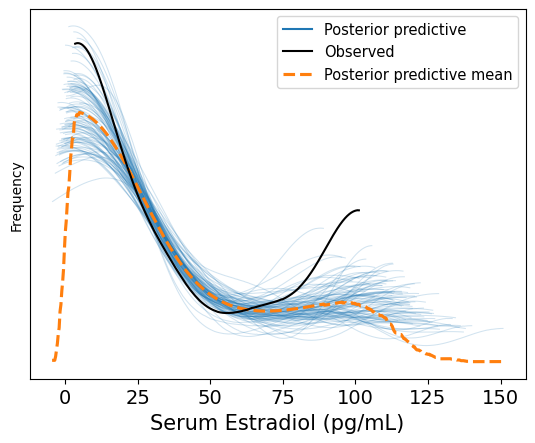

In [80]:
# labeling the plot, https://python.arviz.org/en/stable/api/generated/arviz.plot_ppc.html
# https://python.arviz.org/en/stable/user_guide/label_guide.html#label-guide
# y-axis below is frequency, see https://rlhick.people.wm.edu/stories/bayesian_7.html
import arviz.labels as azl

labeller = azl.MapLabeller(var_name_map={"Likelihood": r"Serum Estradiol (pg/mL)"})
az.plot_ppc(sampleMylan100, num_pp_samples=100, var_names="Likelihood", labeller=labeller);
plt.ylabel('Frequency')
plt.show()

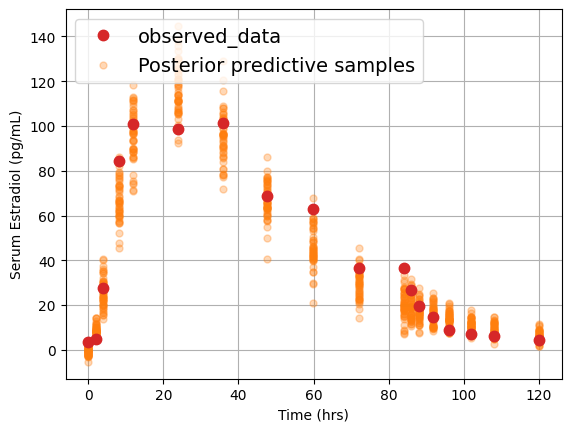

In [81]:
az.plot_lm(idata=sampleMylan100, y="Likelihood", x=MylanTDP100[:,0])
plt.xlabel('Time (hrs)')
plt.ylabel('Serum Estradiol (pg/mL)')
plt.show()

In [112]:
# extract predicted serum Estradiol, https://python.arviz.org/en/stable/api/generated/arviz.r2_score.html

Mylan100Hat = sampleMylan100.posterior_predictive.stack(sample=("chain", "draw"))["Likelihood"].values.T
Mylan100Hat

array([[-2.2184651 , 11.45109128, 33.64321182, ...,  6.02527067,
         9.63989799,  5.8541017 ],
       [ 1.99972811,  7.99641549, 33.62640576, ...,  9.4699772 ,
         7.23613463,  7.71124923],
       [-0.64360503,  5.15153145, 26.40880262, ..., 17.05903499,
        14.67392604,  4.8129928 ],
       ...,
       [ 0.20993201,  5.79032544, 28.16968367, ..., 11.50202377,
        10.89029383,  6.40858236],
       [ 1.1646462 ,  8.32611888, 30.05497445, ...,  9.90538414,
         6.64815856,  7.04280898],
       [-1.87530904,  5.88897351, 16.25496802, ..., 12.04233413,
         9.69298752,  5.35349202]])

In [113]:
# check r^2, r^2=1 => prefect fit
az.r2_score(MylanTDP100[:,1], Mylan100Hat)

r2        0.916848
r2_std    0.026128
dtype: float64